# Introduction
## Simulation of th Palu region Tsunami
The following code simulates the Indonesia Palu area Tsunami.  To do this the following steps are required
* Define the simulation code
* Open Bathymetry database and extract the ocean depth and land heights for the region of interest near palu
* Set up parameters for finite element grid
* Create Disk Memory Map to Virtual memory to allow processing of arrays larger than RAM memory during animation 
* Iterate differential equations, and periodically generate animation frames
Additionally prior to executing various unit test verifications are run
* Define code for unit test on simple 1-D and 2D problems with well known results
* validate assertions that simulation is correct.

### This is not just an annotated program listing but an interactive notebook
This is Jupyter Notebook intereactive environment.  Like a Matalb or Mathematica Notebook, code is divided into input cells, and if there is output from a cell it is displayed below it.  The entrire notebook can be run from start to finish like a traditional program or onne can interactively edit cells (to change parameters or logic) then re-execute cells out of order.  
### Coding styles for massively parallel computation
In the code you will see a mixture of different styles of code idioms that suited for different kinds of computing.  In places the same basic function is re-implemented several ways since it's easier to include debugging, validation code, and __avoid global variables__  in the less restrictive slower syntaxes.
* <b>"pure" Python.  </b>
<br>Strictly scalar effectively single threaded but allows rich object types
* <b>Numpy (typically ~50x faster)</b>
<br>Rich Matrix Operations. "Matlab" copycat syntax, allows operator level multi-processing and SIMD.
* <b>Numba (Can be 100x faster)</b>
<br>Fuses arbitrary scalar code and compiles "pure" python into kernels.  These become fast complex matrix operations for Numpy.  Restricited syntax and no rich object types
* <b>Cuda (can be  1000x faster)</b>
<br>massively threaded SIMT streaming processors on GPU.  Millions of threads running on thousands of cores. Very constrained syntax, strong resource constraints.  Benefit occurs when code can thread easily.

Before we can do much we need to load some libraries
# import some libraries

In [1]:
%matplotlib notebook

# %env
# %env NUMBA_ENABLE_CUDASIM=1

# import scipy as scp
import numpy as np
import numba as nb
from numba import cuda
import operator as op
import time
import matplotlib as mpl
import pandas as pd
from pandas import HDFStore, DataFrame
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, Button
from IPython.display import display, HTML
import netCDF4 as nc
from math import sqrt
mysqrt= sqrt # as opposed to nb.sqrt


# Reader Tutorial: 
## Examples of the four coding styles from scalar to massiviely parallel vector ops.
So the reader can recognize these in the main code, and not get confused, here's a trivial  example for a scalar times a vector implemented in the four idioms.
 

In [2]:
# Pure python style with Numpy arrays

N=1000 # parameter to set size
X = np.ones(N,dtype=np.float32) # make a vector of ones, size N, of 4 byte floats
Out = np.empty(N,dtype=np.float32) # allocate space to put result
a = 2

In [3]:
def pyScale(a,X,Out): 
    dot = 0.0
    for i in nb.prange(X.size):
        Out[i]=X[i]*a

%timeit pyScale(a,X,Out)
    

1.62 ms ± 83.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
# numpy vector style (very compact notation for linear algebra)

Out[:] = a*X

%timeit Out[:]=a*X

1.52 µs ± 142 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [5]:
# numba style to compile python into a parallel kernel

numbaScale = nb.njit(pyScale,fastmath=True,parallel=True)

# execute it
numbaScale(a,X,Out)

%timeit numbaScale(a,X,Out)

4.49 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
#Cuda GPU style.  Limited to on-device memory and only useful for SIMT vector ops.

# move arrays to dedicated GPU memory
d_X = nb.cuda.to_device(X)
d_Out = nb.cuda.to_device(Out)

# kernel for a single thread
def pykernel_scale(a,X,Out):
    i = nb.cuda.grid(1) # thread index
    if i<X.shape[0]:
        Out[i]=a*X[i]

# compile kernel  
cuda_scale_kernel = nb.cuda.jit(pykernel_scale,fastmath=True)

# set up array of streaming multiprocessor threads precisely tuned to array size
blockDim = 256
gridDim = (X.shape[0]+blockDim-1)//blockDim
cuda_scale = cuda_scale_kernel[gridDim,blockDim]

# this schedules blockDim (<1024) simultaneous threads on up to gridDim streaming processors each with 2048 cores.
# thus can have millions of threads on thouands of cores in flight for large arrays

# execute it
cuda_scale(a,d_X,d_Out)

%timeit cuda_scale(a,d_X,d_Out)

# cleanup and release memory
del d_X
del d_Out
del X
# del Y

83.6 µs ± 5.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Define some frequently used constants
Because python defaults to 8 byte ints and floats, whereas GPU memory busses are optimized for 4 byte ints and floats, it's useful to pre-cast some often used constants.

In [7]:
# common numbers in float32 form to speed up calculations
zero = np.float32(0)
p5 = np.float32(0.5)
one = np.float32(1)
two = np.float32(2)

# utility function: First order derivaties for 2D matricies
Derivative is formed by taking difference of adjacent values along one axis, and dividing by delta.

<b>Note while one could define higher order derivative calculations using additional next-nearest neighbors this not useful here.</b> In the later code we will be averaging these derivates making them effectively higher order central differences, and the Rutte Kunga style integrators in use will further average these over time steps making these effectively fourth or fifth order in the results even though we begin with simple first differences.

This is also the first example of using a combination of both Numpy vector ops, and Numba just-in-time run-time compilation.


In [8]:
# First order differential functions

# derivative in x
@nb.njit(fastmath=True,parallel=True)
def d_dx(a, dx):
    return ( a[1:] - a[:-1] )*(np.float32(1)/dx) # ddx

# derivative in y
@nb.njit(fastmath=True,parallel=True)
def d_dy(a, dy):
    return ( a[:,1:] - a[:,:-1] )*(np.float32(1)/dy)


# Tsumani Wave type examples.
This code will be using two different wave shapes for simulation of tsunamis. 
* A simple uplift using a truncated, possibly eliptical, Gaussian
* A "Seismic" shape that is sutied to a slip-fault and other types of waves.

Here are some static images of these common wave models taken from the literature (see References)

Figure 1: simple 2d disturbance
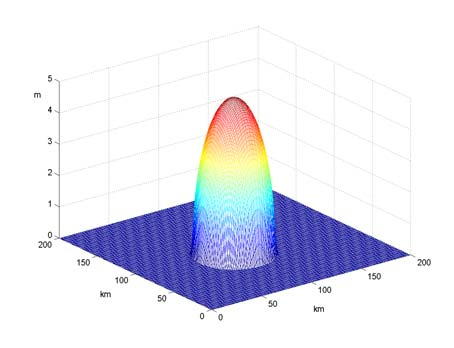

Figure 2: "seismic" disturbance, with negative and positive height deviation
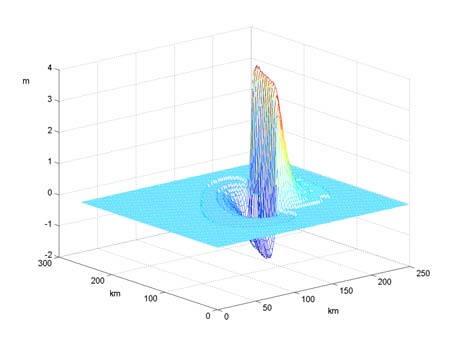

In [9]:
# simple environments or initial conditions

# create a simple 1d gaussian disturbance
def lingauss(shape, w, cx = 0, cy = 0, theta = 0, cutoff = 0.05, norm = False):#, win = (-2, 2)):
    """returns a 1d gaussian on a 2d array of shape 'shape'"""
    x = np.arange(0, shape[0])#linspace( win[0], win[1], shape[0] )
    y = np.arange(0, shape[1])#linspace( win[0], win[1], shape[1] )
    xx, yy = np.meshgrid(x, y, indexing='ij')
    xy = np.cos(theta)*(xx-cx) + np.sin(theta)*(yy-cy) # lin comb of x, y, to rotate gaussian
    h = np.exp( - ( xy*xy ) / (2*w*w) )
    if norm:
        h = h / (np.sqrt(two*np.pi)*w)
    h -= cutoff
    h[np.less(h, zero)] = zero
    return (h)

# creates a simple 2d disturbance (see figure 1)
def planegauss(shape, wx, wy, cx=0, cy=0, theta = 0, cutoff = 0.05, norm = False):
    h1 = lingauss(shape, wx, cx=cx, cy=cy, theta = theta, cutoff=cutoff, norm=norm)
    h2 = lingauss(shape, wy, cx=cx, cy=cy, theta = theta + np.pi/2, cutoff=cutoff, norm=norm)
    return h1*h2

# creates a "seismic" distrubance, with negative and positive height deviation (see figure 2)
def seismic(shape, width, length, cx=0, cy=0, theta=0, a1 = 1, a2 = 1, cutoff=0.05, norm=False):
    """returns simple seismic initial condition on array with shape 'shape'
        theta - angle of rotation
        length - length across distrubance
        width - width across disturbance
        a1 - amplitude of positive portion of distrubance
        a2 - amplitude of negative portion of disturbance
        cx - the x position of the distrubance
        cy - the y position of the disturbance
        cutoff - the magnitude below which values are rounded to zero"""
    offx = width*np.cos(theta)*0.5
    offy = width*np.sin(theta)*0.5
    h1 = a1*planegauss(shape, width, length, cx=cx+offx, cy=cy+offy, theta = theta, cutoff=cutoff, norm=norm) # 'hill'
    h2 = -a2*planegauss(shape, width, length, cx=cx-offx, cy=cy-offy, theta = theta, cutoff=cutoff, norm=norm) # 'valley'
    return h1+h2

In [10]:
# physics constants
class p():
    g = np.float32(9.81) # gravity

# Boundary Contitions
    
## handling land/coastline and the limits of the simulated area
There are two different boundaries that are handled differently
* <b>The Land and Land-sea boundary </b><br>
    Reflective boundary condition at the interface by setting the X and Y Velocity is set to zero.
    
* <b> Non-Reflective borders</b><br>
    Exiting boundary conditions. At the edges of the simulation matrix the wave height and wave speeds are very slowly atteunated over a margin region to prevent unwanted reflections for these artifical boundaries.  This approximates the waves exiting the simulation region. 

### Vector code style
Here we see that the same methods are implemented two different ways. 
* Numpy vector syntax
* Cuda GPU syntax


In [11]:
# functions to handle coast and boundaries

def land(h, n, u, v, coastx): # how to handle land/above water area
    (u[1:])[coastx] = zero
    (u[:-1])[coastx] = zero # set vel. on either side of land to zero, makes reflective
    (v[:,1:])[coastx] = zero
    (v[:,:-1])[coastx] = zero
#     n[coastx] = zero
    return (n, u, v)


def border(n, u, v, margwidth=15, alph=np.array([0.95, 0.95, 0.95, 0.5])):
    """near one = fake exiting ( attenuate off edges)
    1 = reflective"""
    # attenuate off edges to minimize reflections
    n[0:margwidth] *= alph[0]
    u[0:margwidth] *= alph[0]
    v[0:margwidth] *= alph[0]
    
    n[-1:-margwidth-1:-1] *= alph[1]
    u[-1:-margwidth-1:-1] *= alph[1]
    v[-1:-margwidth-1:-1] *= alph[1]
    
    n[:,0:margwidth] *= alph[2]
    u[:,0:margwidth] *= alph[2]
    v[:,0:margwidth] *= alph[2]
    
    n[:,-1:-margwidth-1:-1] *= alph[3]
    u[:,-1:-margwidth-1:-1] *= alph[3]
    v[:,-1:-margwidth-1:-1] *= alph[3]
    
#     return n, u, v

In [12]:
@nb.cuda.jit(fastmath=True)
def land_cuda(h, u, v, coastx):
    i,j = cuda.grid(2)
    u[i+1,j] *= coastx[i,j]
    u[i  ,j] *= coastx[i,j]
    v[i,j+1] *= coastx[i,j]
    v[i,j  ] *= coastx[i,j]
#     return u, v



@nb.cuda.jit(fastmath=True)
def border_cuda(n, u, v, margwidth=15, alph=np.float32([0.95, 0.95, 0.95, 0.5])):
    """near one = fake exiting ( attenuate off edges)
    1 = reflective"""
    i, j = nb.cuda.grid(2)
    a0 = alph[0]
    a1 = alph[1]
    a2 = alph[2]
    a3 = alph[3]
    for ii in range(margwidth):
        n[ii,j] *= a0
        u[ii,j] *= a0
        v[ii,j] *= a0
        
    for ii in range(n.shape[0]-margwidth, n.shape[0]):
        n[ii,j] *= a1
        u[ii+1,j] *= a1
        v[ii,j] *= a1
    
    for jj in range(margwidth):
        n[i,jj] *= a2
        u[i,jj] *= a2
        v[i,jj] *= a2
        
    for jj in range(n.shape[1]-margwidth, n.shape[1]):
        n[i,jj] *= a3
        u[i,jj] *= a3
        v[i,jj+1] *= a3
    
    # could recount corners to mimic numpy version, but not worth the effort
#     if i+j == 0:

## Physics model
The core simulation engine will simulate the shallow water differential equations.

Equations of motion
$$
\begin{align}
\frac{\partial \eta}{\partial t} & =
    -\frac{\partial  }{\partial x} \bigl( \left( \eta + h\right)u \bigr) 
    - \frac{\partial  }{\partial y}  \bigl( \left( \eta + h\right)v \bigr)\\  
\\
\frac{\partial u}{\partial t} & = Coriolis + Advection + Gravity + Attenuation\\
 & = +fv +\bigl( \kappa\nabla^{2}u - (u,v)\cdot\vec\nabla u \bigr)  
    - g\frac{\partial \eta}{\partial x} - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\  
& = +fv +\bigl( \kappa\frac{\partial^{2} u}{\partial x^{2}}
           +\kappa\frac{\partial^{2} u}{\partial y^{2}}
           -u\frac{\partial u}{\partial x} - v\frac{\partial u}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial x}
            - \frac{1}{\rho (h + \eta)} \mu u \sqrt{u^{2} + v^{2}}\\
\\
\frac{\partial v}{\partial t} & = -fu 
   + \bigl( \kappa\nabla^{2}v - (u,v)\cdot\vec\nabla v \bigr) 
    - g\frac{\partial \eta}{\partial y}
    - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\   
& = -fu+\bigl( \kappa\frac{\partial^{2} v}{\partial x^{2}}
           +\kappa\frac{\partial^{2} v}{\partial y^{2}}
           -u\frac{\partial v}{\partial x} - v\frac{\partial v}{\partial y}\bigr) 
           - g\frac{\partial \eta}{\partial y}
           - \frac{1}{\rho (h + \eta)} \mu v \sqrt{u^{2} + v^{2}}\\           
\end{align}
$$

Where 
- *_h_* calm ocean depth (positive number) at any point. Presumed constant in time
- $\eta$ is the wave height or sea surface height deviation from normal
- *_u_* is the mean water column velocity in the _x_ (east) direction
- *v* is the mean water column velocity in the _y_ (north) direction

and the physcial constant parameters are:
- *g* gravitational constant
- *f* is the lattidude dependent coriolis coefficient: $2\omega \sin(latitude)$
- $\kappa$ is the viscous damping coefficient across the grid cell boundaries
- $\mu$ is the friction coeffecient


# Rate of change of wave height dn/dt
This is implemented 3 ways
* Numpy Vector style
* Numba Compiled
* GPU Kernel

In [13]:
zero = np.float32(0)
p5 = np.float32(0.5)
one = np.float32(1)
two = np.float32(2)

def dndt(h, n, u, v, dx, dy, out) :
# def dndt(state):
    """change in n per timestep, by diff. equations"""
#     h, n, u, v, dx, dy = [qp.asnumpy(state.__dict__[k]) for k in ('h', 'n', 'u', 'v', 'dx', 'dy')]
    hx = np.empty(u.shape, dtype=n.dtype) # to be x (u) momentum array
    hy = np.empty(v.shape, dtype=n.dtype)
    
    depth = h+n
    hx[1:-1] = (depth[1:] + depth[:-1])*p5 # average
    hx[0] = zero # normal flow boundaries/borders
    hx[-1] = zero # the water exiting the water on the edge is n+h
    
    hy[:,1:-1] = (depth[:,1:] + depth[:,:-1])*p5
    hy[:,0] = zero
    hy[:,-1] = zero
    
    hx *= u # height/mass->momentum of water column.
    hy *= v
    out[:,:] = d_dx(hx, -dx)+d_dy(hy, -dy)
#     return ( d_dx(hx, -dx)+d_dy(hy, -dy) )
 # change in x vel. (u) per timestep

In [14]:
# Single thread scalar function in python
def dndt2(jx, iy, h, n, u, v, dx, dy) :
    """change in n per timestep, by diff. equations"""
    p5 = np.float32(0.5)
    depth_jm0im0 = h[jx,  iy  ]+n[jx,    iy]
    depth_jp1im0 = h[jx+1,iy]  +n[jx+1,iy]
    depth_jm1im0 = h[jx-1,iy]  +n[jx-1,iy]
    depth_jm0ip1 = h[jx,  iy+1]+n[jx,  iy+1]
    depth_jm0im1 = h[jx,  iy-1]+n[jx,  iy-1]
    
    hx_jp1 = u[jx+1,iy]*(depth_jm0im0 + depth_jp1im0)*p5
    hx_jm0 = u[jx,  iy]*(depth_jm1im0 + depth_jm0im0)*p5
    
    
    hy_ip1 = v[jx,iy+1]*(depth_jm0im0 + depth_jm0ip1)*p5
    hy_im0 = v[jx,iy  ]*(depth_jm0im1 + depth_jm0im0)*p5
    
    # assume u and v are zero on edge
    dhx = (hx_jp1-hx_jm0)/dx#[jx,iy]
    dhy = (hy_ip1-hy_im0)/dy#[jx,iy]
    return ( -dhx-dhy )

# compile the scalar function to a cuda device function
ndevice_compiler_numba = nb.njit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32)',parallel=True,fastmath=True)
dndt2_numba = ndevice_compiler_numba (dndt2)

# numba kernel to drive function 
def dndt_drive_py(h, n, u, v, dx, dy, out):      
    for jx in nb.prange(1,out.shape[0]-1):  #wrong 2?
        for iy in range(1,out.shape[1]-1):
            out[jx,iy] = dndt2_numba(jx, iy, h, n, u, v, dx, dy)
    out[ 0,:] = out[ 1,:]
    out[-1,:] = out[-2,:]
    out[:, 0] = out[:, 1]
    out[:,-1] = out[:,-2]   
# compile numba kernel
dndt_drive_numba = nb.njit(dndt_drive_py,parallel=True, fastmath=True)

In [15]:
ndevice_compiler_cuda =  nb.cuda.jit('float32(int32,int32,float32[:,:],float32[:,:],\
float32[:,:],float32[:,:],float32,float32)',device=True,fastmath=True)

dndt2_cuda = ndevice_compiler_cuda(dndt2)

def dndt_drive_cuda(h, n, u, v, dx, dy, out):
    iy ,jx= nb.cuda.grid(2)
    if out.shape[0]-1>jx>0  and out.shape[1]-1>iy>0:
        out[jx,iy] = dndt2_cuda(jx,iy,h,n,u,v,dx,dy)
    else:  # could lose this since we don't care! 
        if jx == 0 or  jx == out.shape[0]-1:
            if out.shape[1]>iy:
                out[jx,iy] = np.float32(0.0)
        elif iy == 0 or  iy == out.shape[1]-1:
            if out.shape[0]>jx:
                out[jx,iy] = np.float32(0.0)

ncompiler =  nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,\
float32,float32[:,:])',fastmath=True)

dndt_drive_cuda=ncompiler(dndt_drive_cuda)

## functions for calculating the rate of change of the velocities of the shallow water system

### numpy syntax (like matlab)
code written for use with the numpy library, which has syntax simillar to that of matlab

In [16]:
# caculate the rate of change of the x velocities in the system
def dudt(h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0.3) :
    mu = np.float32(mu)
    g = p.g
    
    dudt = np.zeros(u.shape, dtype=u.dtype) # x accel array
    
    if grav:
        dudt[1:-1] = d_dx(n, -dx/g)
    
    
    vn = (v[:,1:]+v[:,:-1])*p5 # n shaped v
    
    # coriolis force
    if cori:
        
        fn = f#(f[:,1:]+f[:,:-1])*0.5 # n shaped f
        fvn = (fn*vn) # product of coriolis and y vel.
        dudt[1:-1] += (fvn[1:]+fvn[:-1])*p5 # coriolis force
    
    
    # advection
    
    # advection in x direction
    if advx:
        dudx = d_dx(u, dx)
        dudt[1:-1] -= u[1:-1]*(dudx[1:] + dudx[:-1])*p5 # advection
    
    # advection in y direction
    # possibly average to corners first, then multiply. may be better?
    if advy:
        duy = np.empty(u.shape, dtype=u.dtype)
        dudy = d_dy(u, dy)
        duy[:,1:-1] = ( dudy[:,1:] + dudy[:,:-1] ) * p5
        duy[:,0] = dudy[:,0]
        duy[:,-1] = dudy[:, -1]
        dudt[1:-1] -= (vn[1:]+vn[:-1])*p5*duy[1:-1] # advection
    

    #attenuation new
    if attn:
        vna = (v[:,1:]+v[:,:-1])*p5
        depth = p5*np.abs((h[:-1]+h[1:]+n[:-1]+n[1:])) + one
        v_u = (vna[1:]+vna[:-1])*p5
    #     print(v_u.shape)
        attenu = 1/(depth) * mu * u[1:-1] * np.sqrt(u[1:-1]**2 + v_u**2) # attenuation
        dudt[1:-1] -= attenu

    # viscous term
#     nu = np.float32(1000/dx)

#     ddux = d_dx(dudx, dx)
#     dduy = np.empty(u.shape, dtype=u.dtype)
#     ddudy = d_dy(duy, dy)
#     dduy[:,1:-1] = ( ddudy[:,1:] + ddudy[:,:-1] ) * p5
#     dduy[:,0] = ddudy[:,0]
#     dduy[:,-1] = ddudy[:, -1]
#     dudt[1:-1] -= nu*(ddux+dduy[1:-1])
    
    
    dudt[0] = zero
    dudt[-1] = zero # reflective boundaries
    dudt[:,0] = zero
    dudt[:,-1] = zero # reflective boundaries
    out[:,:] = dudt
#     return ( dudt )




def dvdt(h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0.3) :
    mu = np.float32(mu)
    g = p.g
    
    dvdt = np.zeros(v.shape, dtype=v.dtype) # x accel array
    
    #gravity
    if grav:
        
        dvdt[:,1:-1] = d_dy(n, -dy/g)
    
    
    un = (u[1:]+u[:-1])*p5 # n-shaped u
    
    # coriolis force
    if cori:
        
        fun = (f*un) # product of coriolis and x vel.
        dvdt[:,1:-1] += (fun[:,1:]+fun[:,:-1])*0.5 # coriolis force
        
    
    # advection
    
    # advection in y direction
    if advx:
        dvdy = d_dy(v, dy)
        dvdt[:,1:-1] -= v[:,1:-1]*(dvdy[:,1:] + dvdy[:,:-1])*p5 # advection
    
    # advection in x direction
    if advy:
        dvx = np.empty(v.shape, dtype=v.dtype)
        dvdx = d_dx(v, dx)
        dvx[1:-1] = ( dvdx[1:] + dvdx[:-1] ) * p5
        dvx[0] = dvdx[0]
        dvx[-1] = dvdx[-1]
        dvdt[:,1:-1] -= (un[:,1:]+un[:,:-1])*p5*dvx[:,1:-1] # advection
    
    
    # attenuation
    if attn:
        una = (u[1:]+u[:-1]) * p5
        depth = p5*np.abs(h[:,:-1]+h[:,1:]+n[:,:-1]+n[:,1:]) + one
        uv = (una[:,1:]+una[:,:-1])*p5
        dvdt[:,1:-1] -= mu * v[:,1:-1] * np.sqrt(v[:,1:-1]**2 + uv*uv) / depth
    
    
    # viscous term
#     nu = np.float32(dy/1000) # nu given as argument

#     ddvy = d_dy(dvdy, dy)
#     ddvx = np.empty(v.shape, dtype=v.dtype)
#     ddvdx = d_dx(dvx, dx)
#     ddvx[1:-1] = ( ddvdx[1:] + ddvdx[:-1] ) * p5
#     ddvx[0] = ddvdx[0]
#     ddvx[-1] = ddvdx[-1]
#     dvdt[:,1:-1] -= nu*(ddvy+ddvx[:,1:-1])

#     dvdt[:,0] += nu*ddvx[:,0]*ddvy[:,0]
#     dvdt[:,-1] += nu*ddvx[:,-1]*ddvy[:,-1]
    
    dvdt[0] = zero
    dvdt[-1] = zero # reflective boundaries
    dvdt[:,0] = zero
    dvdt[:,-1] = zero # reflective boundaries
    out[:,:] = dvdt
#     return dvdt


### python syntax with looping over array - with numba
   Looping over the array should take much longer than doing array calculations - however, using the numba library and compiling the function to numba, it goes much faster than even the version with array calculations.

In [17]:
# calculate the rate of change of the x velocity of a single point
def dudt2(jx, iy, h, n, f, u, v, dx, dy, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0) :
    mu = np.float32(mu)
    p5 = np.float32(0.5)
    one = np.float32(1)
    g=np.float32(9.81)
    
    jxm1= jx-1
    iym1= iy-1
    jxp1= jx+1
    iyp1= iy+1
    jxm0= jx
    iym0= iy
    
    dudt = 0
    
    # gravity
    if grav:
        dudt -= g * ( n[jxm0, iym0] - n[jxm1, iym0] ) / dx
    
    
    vn_jm1 = (v[jxm1,iym0]+v[jxm1,iyp1])*p5
    vn_jm0 = (v[jxm0,iym0]+v[jxm0,iyp1])*p5
    
    # coriolis force
    if cori:
        

        vf_jm1im0 = f[jxm1,0]*vn_jm1  # techically the iy lookup on f is irrelevant
        vf_jm0im0 = f[jxm0,0]*vn_jm0

        dudt +=  (vf_jm0im0 + vf_jm1im0)*p5
    
    # advection
    
    # advection in x direction
    if advx:
        dudx_jp1 = (u[jxp1,iym0]-u[jxm0,iym0])/dx
        dudx_jm0 = (u[jxm0,iym0]-u[jxm1,iym0])/dx
        dudt -= u[jxm0,iym0]*(dudx_jp1+dudx_jm0)*p5
    
    
    # advection in y direction
    if advy:
        dudy_ip1 = (u[jxm0,iyp1]-u[jxm0,iym0])/dy
        dudy_im0 = (u[jxm0,iym0]-u[jxm0,iym1])/dy

        vu = (vn_jm1+vn_jm0)*p5

        dudt -= vu*(dudy_ip1 + dudy_im0)*p5 # wrong? multiply in other order?
    
    
    #attenuation
    if attn:
        h_jm0 = (h[jxm1,iym0]+h[jxm0,iym0])*p5
        n_jm0 = (n[jxm1,iym0]+n[jxm0,iym0])*p5
        depth = abs(h_jm0+n_jm0)+one
    #     if depth == 0: print ('yikes! zero depth!')
        dudt -= mu * u[jx,iy] * mysqrt(u[jx,iy]**2 + vu*vu) / depth
    
    
    # viscous term
    #
    
    return ( dudt )

device_compiler_numba = nb.njit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,b1,b1,b1,b1,b1,float32,float32)',parallel=True,fastmath=True)

dudt2_numba = device_compiler_numba(dudt2)

def dudt_drive_py(h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0):
    for jx in nb.prange(1, u.shape[0]-1):
        for iy in nb.prange(1, u.shape[1]-1):
            out[jx,iy] = dudt2_numba(jx,iy,h,n,f,u,v,dx,dy, grav, cori, advx, advy, attn,nu,mu)
    # handle edges
    out[ 0,:] = -out[ 2,:]
    out[-1,:] = -out[-3,:]
    out[ 1,:] = zero
    out[-2,:] = zero

dudt_drive_numba = nb.njit(dudt_drive_py,parallel=True, fastmath=True)



def dvdt2(jx, iy, h, n, f, u, v, dx, dy, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0) :
    mu = np.float32(mu)
    p5 = np.float32(0.5)
    one = np.float32(1)
    g=np.float32(9.81)

    jxm1= jx-1
    iym1= iy-1
    jxp1= jx+1
    iyp1= iy+1
    jxm0= jx
    iym0= iy
    
    dvdt = 0
    
    if grav:
        dvdt -= g * ( n[jxm0, iym0] - n[jxm0, iym1] ) / dy
    
    
    un_im1 = (u[jxm0,iym1]+u[jxp1,iym1])*p5
    un_im0 = (u[jxm0,iym0]+u[jxp1,iym0])*p5
    uv = (un_im0 + un_im1)*p5
    
    # coriolis force
    if cori:
        dvdt +=  f[jxm0,0]*uv
    
    
    # advection
    
    ## advection in y direction
    if advx:
        dvdy_ip1 = (v[jxm0,iyp1]-v[jxm0,iym0])/dy
        dvdy_im0 = (v[jxm0,iym0]-v[jxm0,iym1])/dy
        dvdt -= v[jxm0,iym0]*(dvdy_ip1+dvdy_im0)*p5
    
    ## advection in x direction
    if advy:
        dvdx_jp1 = (v[jxp1,iym0]-v[jxm0,iym0])/dx
        dvdx_jm0 = (v[jxm0,iym0]-v[jxm1,iym0])/dx
        dvdt -= uv*(dvdx_jp1 + dvdx_jm0)*p5 # wrong? multiply in other order?
    
    # attenuation
    if attn:
        h_im0 = (h[jxm0,iym1]+h[jxm0,iym0])*p5
        n_im0 = (n[jxm0,iym1]+n[jxm0,iym0])*p5
        depth = abs(h_im0+n_im0) + one
    #     if depth == 0: print('yikes! zero depth!')
        dvdt -= mu * v[jxm0,iym0] * mysqrt(v[jxm0,iym0]**2 + uv*uv) / depth
       # DUMMYDUMMYDUMMY = mu * v[jx,iy] * mysqrt(v[jx,iy]**2 + uv*uv) / depth
    
    return ( dvdt )

dvdt2_numba = device_compiler_numba (dvdt2)

def dvdt_drive_py(h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0):   
    for jx in nb.prange(1, v.shape[0]-1):
        for iy in nb.prange(1, v.shape[1]-1):
            out[jx,iy] = dvdt2_numba(jx,iy,h,n,f,u,v,dx,dy,grav, cori, advx, advy, attn,nu,mu)
    out[:, 0] = -out[:, 2]
    out[:,-1] = -out[:,-3]
    out[:, 1] = zero
    out[:,-2] = zero

dvdt_drive_numba = nb.njit(dvdt_drive_py,parallel=True, fastmath=True)

### cuda
cuda compiles the functions to run on the graphics card, with each cell performing the necessary calculations on a single index of the array. This goes much faster than numpy or numba.

In [18]:
device_compiler_cuda =  nb.cuda.jit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,b1,b1,b1,b1,b1,float32,float32)',device=True,fastmath=True)

dudt2_cuda = device_compiler_cuda(dudt2)

def dudt_drive_cuda(h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0):
    iy ,jx= nb.cuda.grid(2)
    #print(jx,iy,jx == 0 or  jx == out.shape[0]-1,out.shape[1]>iy, iy == 0 or  iy == out.shape[1]-1,out.shape[0]>jx)
    if out.shape[0]-1>jx>0  and out.shape[1]-1>iy>0:
        out[jx,iy] = dudt2_cuda(jx,iy,h,n,f,u,v,dx,dy, grav, cori, advx, advy, attn,nu,mu)
    else:  # could lose this since we don't care! 
        if jx == 0 or  jx == out.shape[0]-1:
            if out.shape[1]>iy:
                   out[jx,iy] = np.float32(0.0)
        elif iy == 0 or  iy == out.shape[1]-1:
            if out.shape[0]>jx:
                   out[jx,iy] = np.float32(0.0)
compiler =  nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32[:,:],b1,b1,b1,b1,b1,float32,float32)',fastmath=True)
# %env NUMBA_ENABLE_CUDASIM=1
dudt_drive_cuda=compiler(dudt_drive_cuda)
# %env NUMBA_ENABLE_CUDASIM=0





device_compiler_cuda =  nb.cuda.jit('float32(int32,int32,float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,b1,b1,b1,b1,b1,float32,float32)',device=True,fastmath=True)

dvdt2_cuda = device_compiler_cuda(dvdt2)

def dvdt_drive_cuda(h, n, f, u, v, dx, dy, out, grav=True, cori=True, advx=True, advy=True, attn=True, nu=0, mu=0):
    iy ,jx= nb.cuda.grid(2)
    #print(jx,iy,jx == 0 or  jx == out.shape[0]-1,out.shape[1]>iy, iy == 0 or  iy == out.shape[1]-1,out.shape[0]>jx)
    if out.shape[0]-1>jx>0  and out.shape[1]-1>iy>0:
        out[jx,iy] = dvdt2_cuda(jx,iy,h,n,f,u,v,dx,dy,grav, cori, advx, advy, attn,nu,mu)
    else:  # could lose this since we don't care! 
        if jx == 0 or  jx == out.shape[0]-1:
            if out.shape[1]>iy:
                   out[jx,iy] = np.float32(0.0)
        elif iy == 0 or  iy == out.shape[1]-1:
            if out.shape[0]>jx:
                   out[jx,iy] = np.float32(0.0)

compiler =  nb.cuda.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32[:,:],b1,b1,b1,b1,b1,float32,float32)',fastmath=True)

dvdt_drive_cuda=compiler(dvdt_drive_cuda)

## timestep integrators
there are multiple different ways of integrating the differential equation system.
1. Forward Euler <br>
    the most simple timestepping scheme, simply adding the derivative of each value to the value
2. Forward-Backward <br>
    based off the forward euler timestep, but with an added level of complexity, shifting some of the calculation into being interpolation rather than extrapolation, and thereby being more accurate and stable.
3. Forward-Backward Predictor Corrector <br>
    makes an initial prediction using a forward-backward timestep, and the corrects on that prediction for more accuracy and higher stability
4. Generalized Forward-Backward <br>
    Incorporates values from 2 or 3 previous timesteps, bypassing discarded predictor step to gain speed, at the expense of using additional memory.  

In [19]:
def forward(h, n, u, v, f, dt, dx, dy, du, dv, dn, \
            beta=0, eps=0, gamma=0, mu=0.3, nu=0, \
            dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
            grav=True, cori=True, advx=True, advy=True, attn=True): # forward euler and forward/backward timestep
    """
        beta = 0 forward euler timestep
        beta = 1 forward-backward timestep
    """
    beta = np.float32(beta)
    mu = np.float32(mu)
    
    du1, du0 = du[:2]
    dv1, dv0 = dv[:2]
    dn0 = dn[0]
    
    dndt_x(h, n, u, v, dx, dy, dn0) # calculate dndt and put it into dn0
    
    n1 = n + ( dn0 )*dt
    
    dudt_x(h, n,  f, u, v, dx, dy, du0, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dvdt_x(h, n,  f, u, v, dx, dy, dv0, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dudt_x(h, n1, f, u, v, dx, dy, du1, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dvdt_x(h, n1, f, u, v, dx, dy, dv1, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    
    u1 = u + ( beta*du1 + (one-beta)*du0 )*dt
    v1 = v + ( beta*dv1 + (one-beta)*dv0 )*dt
    
    n, u, v = n1, u1, v1
    
    du = [du1, du0, du0, du0]
    dv = [dv1, dv0, dv0, dv0]
    dn = [dn0, dn0, dn0]
    return n1, u1, v1, du, dv, dn

In [20]:
def fbfeedback(h, n, u, v, f, dt, dx, dy, du, dv, dn, \
               beta=1/3, eps=2/3, gamma=0, mu=0.3, nu=0, \
               dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
               grav=True, cori=True, advx=True, advy=True, attn=True):
    """
        predictor (forward-backward) corrector timestep
    """
    beta = np.float32(beta)
    eps = np.float32(eps)
    mu = np.float32(mu)
    
    du0, du1, du1g = du[:3]
    dv0, dv1, dv1g = dv[:3]
    dn0, dn1 = dn[:2]
    
    #predict
    n1g, u1g, v1g, dug, dvg, dng = forward(h, n, u, v, f, dt, dx, dy, du, dv, dn, beta, mu=mu, nu=nu,\
                                           dudt_x=dudt_x, dvdt_x=dvdt_x, dndt_x=dndt_x, \
                                           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn) # forward-backward first guess
    
    #feedback on prediction
    
    dndt_x(h, n1g,u1g,v1g,dx, dy, dn1)
    dn0 = dng[0]
#     dndt_x(h, n,  u,  v,  dx, dy, dn0)
    
    n1 = n + p5*(dn1 + dn0)*dt
    
    du0 = dug[1]
    dv0 = dvg[1]
#     dudt_x(h, n,  f, u,  v,  dx, dy, du0,  grav=grav, cori=cori, advx=advx, advy=advy, attn=attn)
#     dvdt_x(h, n,  f, u,  v,  dx, dy, dv0,  grav=grav, cori=cori, advx=advx, advy=advy, attn=attn)
    dudt_x(h, n1g,f, u1g,v1g,dx, dy, du1g, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dvdt_x(h, n1g,f, u1g,v1g,dx, dy, dv1g, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dudt_x(h, n1, f, u,  v,  dx, dy, du1,  grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    dvdt_x(h, n1, f, u,  v,  dx, dy, dv1,  grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)

    u1 = u + p5*(eps*du1+(one-eps)*du1g+du0)*dt
    v1 = v + p5*(eps*dv1+(one-eps)*dv1g+dv0)*dt
    
#     n[:,:], u[:,:], v[:,:] = n1, u1, v1
    du, dv, dn = [du1, du0, du0, du0], [dv1, dv0, dv0, dv0], [dn0, dn0, dn0]
    return n1, u1, v1, du, dv, dn

In [21]:
p5=np.float32(0.5)
p32 =np.float32(1.5)
def genfb(h, n, u, v, f, dt, dx, dy, \
          du,dv,dn,\
          beta=0.281105, eps=0.013, gamma=0.0880, mu=0.3, nu=0, \
          dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
          grav=True, cori=True, advx=True, advy=True, attn=True): # generalized forward backward feedback timestep
    """
        generalized forward backward predictor corrector
    """
    
    beta = np.float32(beta)
    eps = np.float32(eps)
    gamma = np.float32(gamma)
    mu = np.float32(mu)
    
    
    dn_m1,dn_m2,dn_m0 = dn     # unpack
    dndt_x(h, n, u, v, dx, dy, dn_m0)
    
    # must do the following before the u and v !
    n1 = n + ((p32+beta)* dn_m0 - (p5+beta+beta)* dn_m1+ (beta)* dn_m2)*dt
    #del  dn_m2
    du_m0,du_m1,du_m2,du_p1 = du     # unpack
    dudt_x(h, n1, f, u, v, dx, dy, du_p1, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)

    dv_m0,dv_m1,dv_m2,dv_p1 = dv     # unpack   
    dvdt_x(h, n1, f, u, v, dx, dy, dv_p1, grav=grav, cori=cori, advx=advx, advy=advy, attn=attn,nu=nu,mu=mu)
    
    
    u1 = u+ ((p5+gamma+eps+eps)*du_p1 +(p5-gamma-gamma-eps-eps-eps)*du_m0 +gamma*du_m1+eps*du_m2)*dt
  # del du_m2
    v1 = v+ ((p5+gamma+eps+eps)*dv_p1 +(p5-gamma-gamma-eps-eps-eps)*dv_m0 +gamma*dv_m1+eps*dv_m2)*dt
   # del dv_m2

    
    
    dv = [ dv_p1,dv_m0,dv_m1,dv_m2 ]
    du = [ du_p1,du_m0,du_m1,du_m2 ]
    dn = [ dn_m0,dn_m1,dn_m2 ]
#     n[:,:], u[:,:], v[:,:], = n1, u1, v1
    return n1, u1, v1, du,dv,dn

In [22]:
@nb.vectorize(['float32(float32,float32,float32,float32)'],target='cuda')
def lin_comb_2(v1, v2, w1, w2):
    return v1*w1 + v2*w2
# tc = nb.vectorize('float32(float32,float32,float32,float32)',target='cuda')
# lin_comb_2 = tc(lin_comb_2_py)
@nb.vectorize(['float32(float32,float32,float32,float32,float32,float32)'],target='cuda')
def lin_comb_3(v1, v2, v3, w1, w2, w3):
    return v1*w1 + v2*w2 + v3*w3
@nb.vectorize(['float32(float32,float32,float32,float32,float32,float32,float32,float32)'],target='cuda')
def lin_comb_4(v1, v2, v3, v4, w1, w2, w3, w4):
    return v1*w1 + v2*w2 + v3*w3 + v4*w4
@nb.vectorize(['float32(float32,float32,float32,float32,float32,float32,float32,float32,float32,float32)'],target='cuda')
def lin_comb_5(v1, v2, v3, v4, v5, w1, w2, w3, w4, w5):
    return v1*w1 + v2*w2 + v3*w3 + v4*w4 + v5*w5


@nb.numba.jit('void(float32[:,:],float32[:,:],float32,float32,float32[:,:])')
def lincomb2(v1, v2, w1, w2, out):
    out[:,:] = lin_comb_2(v1, v2, w1, w2)
@nb.numba.jit('void(float32[:,:],float32[:,:],float32[:,:],float32,float32,float32,float32[:,:])')
def lincomb3(v1, v2, v3, w1, w2, w3, out):
    out[:,:] = lin_comb_3(v1, v2, v3, w1, w2, w3)
@nb.numba.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32,float32,float32[:,:])')
def lincomb4(v1, v2, v3, v4, w1, w2, w3, w4, out):
    out[:,:] = lin_comb_4(v1, v2, v3, v4, w1, w2, w3, w4)
@nb.numba.jit('void(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32,float32,float32,float32,float32,float32[:,:])')
def lincomb5(v1, v2, v3, v4, v5, w1, w2, w3, w4, w5, out):
    out[:,:] = lin_comb_5(v1, v2, v3, v4, v5, w1, w2, w3, w4, w5)

In [23]:
# @nb.cuda.jit(fastmath=True)
def genfb_py(h, n, u, v, f, dt, dx, dy, doland, coastx, bounds,\
          du,dv,dn,\
          beta=0.281105, eps=0.013, gamma=0.0880, mu=0.3, nu=0, \
          dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
          grav=True, cori=True, advx=True, advy=True, attn=True): # generalized forward backward feedback timestep
    """
        generalized forward backward predictor corrector
    """
    
    p5   = np.float32(0.5)
    one  = np.float32(1)
    p32  = np.float32(1.5)
    beta = np.float32(beta)
    eps  = np.float32(eps)
    gamma= np.float32(gamma)
    mu   = np.float32(mu)
    
    dn_m1,dn_m2,dn_m0 = dn[0], dn[1], dn[2]     # unpack
    dndt_x(h, n, u, v, dx, dy, dn_m0)
    
    # must do the following before the u and v !
    #n1 = n + ((p32+beta)* dn_m0 - (p5+beta+beta)* dn_m1+ (beta)* dn_m2)*dt
    lincomb4(n, dn_m0, dn_m1, dn_m2, one, (p32+beta)*dt, -(p5+beta+beta)*dt, (beta)*dt, n)
    
    du_m0,du_m1,du_m2,du_p1 = du[0], du[1], du[2], du[3]     # unpack
    dudt_x(h, n, f, u, v, dx, dy, du_p1, grav, cori, advx, advy, attn,nu,mu)

    dv_m0,dv_m1,dv_m2,dv_p1 = dv[0], dv[1], dv[2], dv[3]     # unpack   
    dvdt_x(h, n, f, u, v, dx, dy, dv_p1, grav, cori, advx, advy, attn,nu,mu)
    
    #u1 = u+ ((p5+gamma+eps+eps)*du_p1 +(p5-gamma-gamma-eps-eps-eps)*du_m0 +gamma*du_m1+eps*du_m2)*dt
    lincomb5(u, du_p1, du_m0, du_m1, du_m2, one, (p5+gamma+eps+eps)*dt, (p5-gamma-gamma-eps-eps-eps)*dt, gamma*dt, eps*dt, u)
    #v1 = v+ ((p5+gamma+eps+eps)*dv_p1 +(p5-gamma-gamma-eps-eps-eps)*dv_m0 +gamma*dv_m1+eps*dv_m2)*dt
    lincomb5(v, dv_p1, dv_m0, dv_m1, dv_m2, one, (p5+gamma+eps+eps)*dt, (p5-gamma-gamma-eps-eps-eps)*dt, gamma*dt, eps*dt, v)

    
    #u, v = 
#     doland(h, u, v, coastx) # how to handle land/coast
#     border(n, u, v, 15, bounds)
    
    dv = [ dv_p1,dv_m0,dv_m1,dv_m2 ]
    du = [ du_p1,du_m0,du_m1,du_m2 ]
    dn = [ dn_m0,dn_m1,dn_m2 ]
    return n, u, v, du,dv,dn

In [24]:
def donothing (h, n, u, v, f, dt, dx, dy, nu, coastx, bounds, mu, itr): return

In [25]:
def simulate(initstate, t, timestep=forward, drive=donothing, landthresh=10,\
             bounds = [0.97, 0.97, 0.97, 0.97], saveinterval=10,\
             beta=0.281105, eps=0.013, gamma=0.0880, mu=0.3, nu=0, \
             dudt_x = dudt, dvdt_x = dvdt, dndt_x = dndt, \
             grav=True, cori=True, advx=True, advy=True, attn=True): # gives surface height array of the system after evert dt
    """
        evolve shallow water system from initstate over t seconds
        returns:
            ntt (numpy memmap of n through time) numpy array,
            maxn (the maximum value of n over the duration at each point) numpy array,
            minn (the minimum value of n over the duration at each point) numpy array,
            timemax (the number of seconds until the maximum height at each point) numpy array
    """
    bounds = np.asarray(bounds, dtype=np.float32)
    h, n, u, v, f, dx, dy, dt = [initstate[k] for k in ('h', 'n', 'u', 'v', 'lat', 'dx', 'dy', 'dt')]
    
    f = np.float32(((2*2*np.pi*np.sin(f*np.pi/180))/(24*3600))[:,np.newaxis])
    
    
    du = np.zeros_like(u)
    dv = np.zeros_like(v)
    dn = np.zeros_like(n)
    
    dudt_x(h, n, f, u, v, dx, dy, du)
    du = [du, du, du, du]
    
    dvdt_x(h, n, f, u, v, dx, dy, dv)
    dv = [dv, dv, dv, dv]
    
    dndt_x(h, n, u, v, dx, dy, dn)
    dn = [dn, dn, dn]
    
    nu = (dx+dy)/1000
    
    mmax = np.max(np.abs(n))
#     landthresh = 1.5*np.max(n) # threshhold for when sea ends and land begins
    itrs = int(np.ceil(t/dt))
    saveinterval = np.int(saveinterval//dt)
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    
    ntt = np.zeros((np.int(np.ceil(itrs/saveinterval)),)+n.shape, dtype=np.float32)
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
    
    coastx = np.less(h, landthresh) # where the reflective condition is enforced on the coast
    
    print('simulating...')
    try:
        for itr in range(itrs):# iterate for the given number of iterations
            if itr%saveinterval == 0:
                ntt[np.int(itr/saveinterval),:,:] = n
                
                
            
            maxn = np.max((n, maxn), axis=0) # record new maxes if they are greater than previous records        
            
            # pushes n, u, v one step into the future
            n, u, v, du1, dv1, dn1 = timestep(h, n, u, v, f, dt, dx, dy, du, dv, dn, \
                                           beta=beta, eps=eps, gamma=gamma, mu=mu, nu=nu, \
                                           dudt_x=dudt_x, dvdt_x=dvdt_x, dndt_x=dndt_x, \
                                           grav=grav, cori=cori, advx=advx, advy=advy, attn=attn)
            
#             land(h, n, u, v, coastx) # how to handle land/coast
#             border(n, u, v, 15, bounds) 
#             drive(h, n, u, v, f, dt, dx, dy, nu, coastx, bounds, mu, itr)
        print('simulation complete')
    except Exception as e:
        print('timestep: ', itr)
        raise e
    return ntt, maxn#, minn, timemax # return surface height through time and maximum heights

In [26]:
def simulate_cuda(initstate, t, timestep=genfb_py, nttname = False, \
             bounds = [1, 1, 1, 1], saveinterval=10,\
             drive=donothing, \
             beta=0.281105, eps=0.013, gamma=0.0880, mu=0.3, nu=0, \
             dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
             grav=True, cori=True, advx=True, advy=True, attn=True): # gives surface height array of the system after evert dt
    """
        evolve shallow water system from initstate over t seconds
        returns:
            ntt (n through time) np.memmap,
            maxn (the maximum value of n over the duration at each point) np.array,
            #minn (the minimum value of n over the duration at each point) np.array,
            #timemax (the number of seconds until the maximum height at each point) np.array
    """
    print("simulate start")
    bounds = np.asarray(bounds, dtype=np.float32)
    h, n, u, v, f, dx, dy, dt = [initstate.__dict__[k] for k in ('h', 'n', 'u', 'v', 'coriolis', 'dx', 'dy', 'dt')]#h, state.n, state.u, state.v, state.dx, state.dy, state.dt
    
#     h[np.logical_and(np.greater(h, -0.1), np.less(h, 0.2))] = np.float32(0.1)

    
    du = np.zeros_like(u)
    dv = np.zeros_like(v)
    dn = np.zeros_like(n)
   
    dndt_x(h, n, u, v, dx, dy, dn)
    dn = (dn, dn.copy(), dn.copy())
    
    dudt_x(h, n, f, u, v, dx, dy, du)
    du = (du, du.copy(), du.copy(), du.copy())
    
    dvdt_x(h, n, f, u, v, dx, dy, dv)
    dv = (dv, dv.copy(), dv.copy(), dv.copy())
    
    
    
    nu = (dx+dy)/1000
    #     state = initstate
    mmax = np.max(np.abs(n))
    landthresh = 1.5*np.max(n) # threshhold for when sea ends and land begins
    itrs = int(np.ceil(t/dt))
    
    saveinterval = np.int(saveinterval//dt)
    assert (dt >= 0), 'negative dt!' # dont try if timstep is zero or negative
    
    ntt = np.zeros((np.int(np.ceil(itrs/saveinterval)),)+n.shape, dtype=np.float32)
#     ntt = np.memmap(str(nttname)+'_eed', dtype='float32', mode='w+', shape=(itrs,)+n.shape)
    maxn = np.zeros(n.shape, dtype=n.dtype) # max height in that area
#     minn = np.zeros(n.shape, dtype=n.dtype) # minimum height that was at each point
#     timemax = np.zeros(n.shape, dtype=n.dtype) # when the maximum height occured
    
    coastx = np.less(h, landthresh) # where the reflective condition is enforced on the coast
#     print('coastx', coastx)
    coastx = np.float32(coastx)
    
    
    ch     = nb.cuda.to_device(h)
    cn     = nb.cuda.to_device(n)
    cu     = nb.cuda.to_device(u)
    cv     = nb.cuda.to_device(v)
#     cout = nb.cuda.to_device(uout)
#     cnout = nb.cuda.to_device(nout)
    cf     = nb.cuda.to_device(f)
    ccoastx= nb.cuda.to_device(coastx)
    cmaxn  = nb.cuda.to_device(maxn)
    cdu    = tuple( [ nb.cuda.to_device(i) for i in du])
    cdv    = tuple( [ nb.cuda.to_device(i) for i in dv])
    cdn    = tuple( [ nb.cuda.to_device(i) for i in dn])
    print("cdn",cdn)
    print("cdn1",cdn[1])
#     cntt = nb.cuda.to_device(ntt)
    
    gridu = ( (cu.shape[1]+32)//32,(cu.shape[0]+32)//32)
    gridv = ( (cv.shape[1]+32)//32,(cv.shape[0]+32)//32)
    gridn = ( (cn.shape[1]+32)//32,(cn.shape[0]+32)//32)
    
    dudt_x = dudt_drive_cuda[gridu,(32,32)]
    dvdt_x = dvdt_drive_cuda[gridv,(32,32)]
    dndt_x = dndt_drive_cuda[gridn,(32,32)]
    
    land   =   land_cuda[gridn,(32,32)]
    border = border_cuda[gridn,(32,32)]
    
    nb.cuda.synchronize()
    print('simulating...')
    try:
        for itr in range(itrs):# iterate for the given number of iterations
#             if itr%saveinterval == 0:
#                 ntt[np.int(itr/saveinterval),:,:] = cn
            
            cn, cu, cv, cdu, cdv, cdn = timestep(ch, cn, cu, cv, cf, dt, dx, dy, land, ccoastx, bounds,\
                                              cdu,cdv,cdn,\
                                              0.281105, 0.013, 0.0880, 0.3, 0, \
                                              dudt_x, dvdt_x, dndt_x, \
                                              grav, cori, advx, advy, attn) # pushes n, u, v one step into the future
            if itr%100 == 0: 
                print(cdn)
                print(cn)
#             if not nttname == False:
#                 cntt[itr] = cn
#             border(cn, cu, cv)
#             cmaxn = nb.max((cn, cmaxn), axis=0) # record new maxes if they are greater than previous records        
#         ntt.flush()
        print('simulation complete')
    except Exception as e:
        print('timestep: ', itr)
        raise e
    return ntt, maxn#, minn, timemax # return surface height through time and maximum heights

## unit test verification
assuming n (the sea surface height) is insignificant compared to h (the depth), then a solution to the shallow water equations can be approximated, giving the wave speed as the square root of the product of the gravity coeffecient and the depth. Using a unit test, the speed a wave propogates at in a small scale simulation is compared to this expected value. The unit tests verifies the wave speed is approximately correct within a reasonable margin of error, and thus verifies the model.

simulating...
simulation complete


<IPython.core.display.Javascript object>


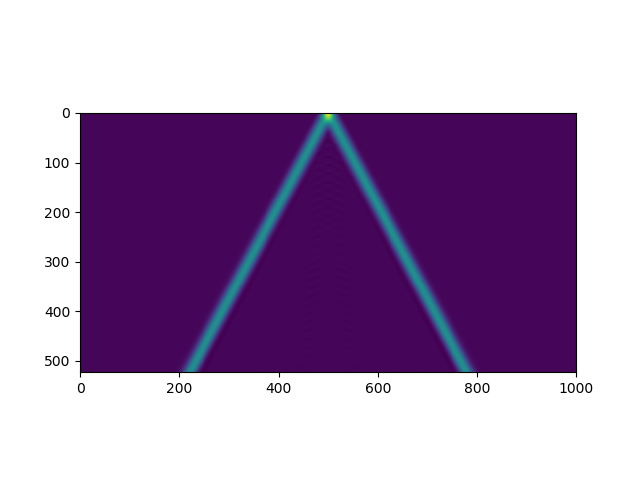

<IPython.core.display.Javascript object>


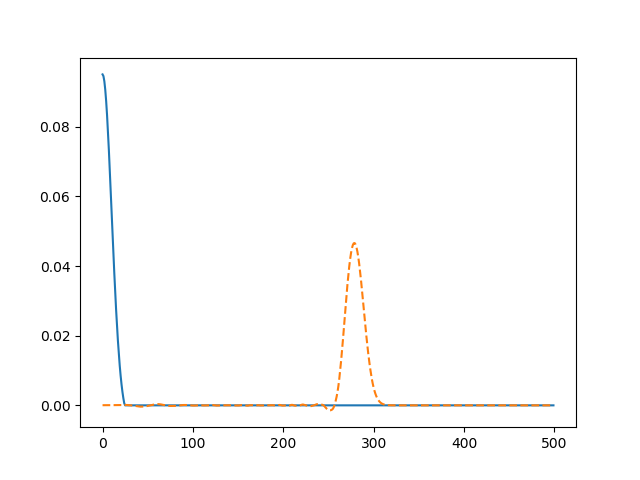

.

279.0 313.2091952673165
-0.10922155474432915 0.15


.
----------------------------------------------------------------------
Ran 2 tests in 2.145s

OK


In [27]:
#wavespeed and differential tests
import unittest
fooo = []
class testWaveSpeed(unittest.TestCase): # tests if the wave speed is correct
    def setUp(self):
        self.dur = 100 # duration of period to calculate speed over
        self.size = (10, 1000) # grid squares (dx's)
        self.dx = np.float32(100) # meters
        self.dy = np.float32(100)
        self.lat = np.linspace(0, 0, self.size[0]) # physical location the simulation is over
        self.lon = np.linspace(0, 0 , self.size[1])
        self.h = np.float32(10000*np.ones(self.size))
        self.n = np.float32(0.1)*lingauss(self.size, 10, cy=500, theta=np.pi/2) # intial condition single wave in the center
        self.u = np.zeros((self.size[0]+1, self.size[1]+0)) # x vel array
        self.v = np.zeros((self.size[0]+0, self.size[1]+1)) # y vel array
        self.dt = 0.3*self.dx/np.sqrt(np.max(self.h)*p.g)
        self.margin = 0.15 # error margin of test
        
        self.initialcondition = {
            'h':self.h,
            'n':self.n,
            'u':self.u,
            'v':self.v,
            'dt':self.dt,
            'dx':self.dx,
            'dy':self.dy,
            'lat':self.lat,
            'lon':self.lon
        }
#         self.testStart = State(self.h, self.n, self.u, self.v, self.dx, self.dy, self.lat, self.lon)
    def calcWaveSpeed(self, ar1, ar2, Dt): # calculat how fast the wave is propagating out
        midstrip1 = ar1[int(ar1.shape[0]/2),int(ar1.shape[1]/2):]
        midstrip2 = ar2[int(ar1.shape[0]/2),int(ar2.shape[1]/2):]
        peakloc1 = np.argmax(midstrip1)
        peakloc2 = np.argmax(midstrip2)
        plt.figure(6)
        plt.clf()
#         plt.subplot(2, 1, 1)
#         plt.imshow(ar1)
#         plt.subplot(2, 1, 2)
#         plt.imshow(ar2)
        plt.plot(midstrip1)
        plt.plot(midstrip2, "--")
#         plt.plot(midstrip1-midstrip2)
        plt.show()
        speed = (peakloc2 - peakloc1)*self.dy/Dt
        return speed
    def calcExactWaveSpeed(self): # approximently how fast the wave should be propagating outwards
        ws = np.sqrt(9.81*np.average(self.h))
        return ws
    def test_wavespeed(self): # test if the expected and calculated wave speeds line up approcimently
        
        self.simdata = simulate(self.initialcondition, self.dur, saveinterval=0.2, \
                                timestep=genfb, bounds=np.array([1, 1, 1, 1]), mu=0, cori=False, advx=False, advy=False, attn=False)
#         self.testFrames, self.testmax, self.testmin = self.simdata[:3]
        fig = plt.figure(7)
        plt.imshow(self.simdata[0][:,5])#self.testStart.n)
#         arts = [(plt.imshow(frame),) for frame in self.simdata[0]]
#         anim = animation.ArtistAnimation(fig, arts)
        
        self.testFrames = self.simdata[0]
        self.testEndN = self.testFrames[-1]
        calcedws = self.calcWaveSpeed( self.initialcondition['n'], self.testEndN, self.dur )
        exactws = self.calcExactWaveSpeed()
        err = (calcedws - exactws)/exactws
        print(calcedws, exactws)
        print(err, self.margin)
        
        assert (abs(err) < self.margin) # error margin
    def tearDown(self):
        del(self.dur)
        del(self.dx)
        del(self.dy)
        del(self.lat)
        del(self.lon)
        del(self.size)
        del(self.h)
        del(self.n)
        del(self.u)
        del(self.v)

class testdifferential(unittest.TestCase): # differental function test (d_dx)
    def setUp(self):
        self.a = np.arange(144) # test input
        self.a = self.a.reshape(12, 12) # make into 2d array
        self.ddthreshold = 1E-16
    def test_ddx(self):
        da = d_dx(self.a, 1)
        diff = np.abs(da[1:-1] - np.mean(da[1:-1]))
        maxdiff = np.max(diff)
        self.assertTrue(np.all(np.abs(da[-1:1] < self.ddthreshold)),"expected zero along borders")
        self.assertTrue(np.all(diff < self.ddthreshold),"Expected constant d_dx less than %f but got %f"%(self.ddthreshold,maxdiff))
    def tearDown(self):
        del(self.a)
        del(self.ddthreshold)

unittest.main(argv=['first-arg-is-ignored'], exit=False)
#You can pass further arguments in the argv list, e.g.
#unittest.main(argv=['ignored', '-v'], exit=False)      
#unittest.main()

### small scale case as verification
running a small scale simulation of a initial disturbance like that from a rock thrown in a pond to verify the model

<IPython.core.display.Javascript object>


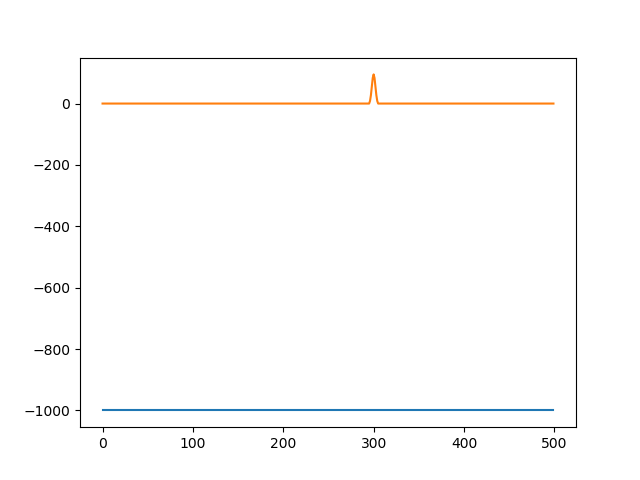

In [77]:
sizex, sizey = 500, 50
oned = {
    'h': np.float32(1000*np.ones((sizex,sizey))),
    'n': np.float32(1*lingauss((sizex, sizey), 2, 300)),
    'u': np.zeros((sizex+1, sizey), dtype=np.float32),
    'v': np.zeros((sizex, sizey+1), dtype=np.float32),
    'dx': np.float32(50),
    'dy': np.float32(50),
    'dt': np.float32(0.1),
    'lat': np.zeros((sizex,)),
    'lon': np.zeros((sizey,))
}
plt.figure()
plt.plot(-oned['h'][:,5])
plt.plot(oned['n'][:,5]*100)
plt.show()

<IPython.core.display.Javascript object>


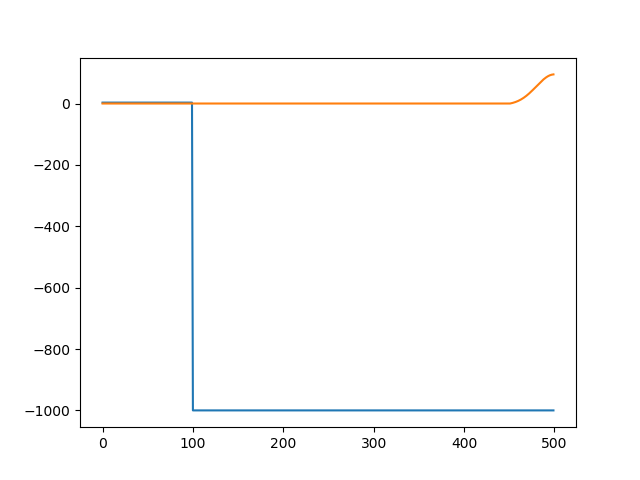

In [78]:
oned2 = {
    'h': np.float32(1000*np.ones((sizex, sizey))),#(1-2*lingauss((sizex, sizey), 20, 20))),
    'n': np.float32(1*lingauss((sizex, sizey), 20, 500)),
    'u': np.zeros((sizex+1, sizey), dtype=np.float32),
    'v': np.zeros((sizex, sizey+1), dtype=np.float32),
    'dx': np.float32(50),
    'dy': np.float32(50),
    'dt': np.float32(0.1),
    'lat': np.zeros((sizex,)),
    'lon': np.zeros((sizey,))
}
oned2['h'][:100] = -3
plt.figure()
plt.plot(-oned2['h'][:,25])
plt.plot(oned2['n'][:,25]*100)
plt.show()

In [79]:
onedframes, onedMax = simulate(oned, 550, timestep=forward, saveinterval=2,\
                               dudt_x = dudt, dvdt_x = dvdt, dndt_x = dndt_drive_numba, \
                               bounds=[1, 1, 1, 1], \
                               grav=True, cori=True, advx=True, advy=True, attn=True)[:2]

simulating...
simulation complete


In [51]:
onedframes2, onedMax2 = simulate(oned, 550, timestep=forward, saveinterval=2,\
                               dudt_x = dudt, dvdt_x = dvdt, dndt_x = dndt, \
                               bounds=[1, 1, 1, 1], \
                               grav=True, cori=True, advx=True, advy=True, attn=True)[:2]

simulating...
simulation complete


<IPython.core.display.Javascript object>


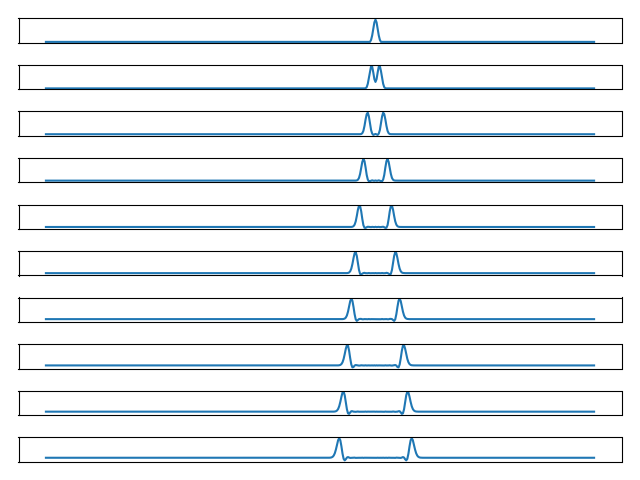

<IPython.core.display.Javascript object>


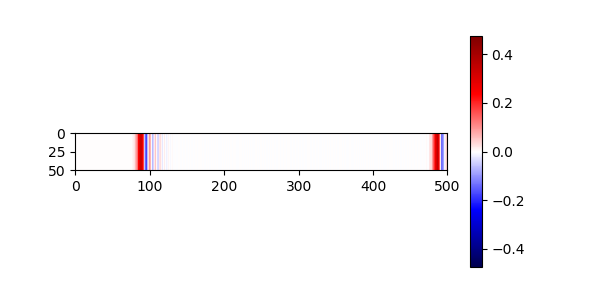

In [83]:
fig = plt.figure(22)#, figsize=(6,3))
mmax = np.max(np.abs(onedframes))/2
plt.imshow(onedframes[:,:,5])
for i in range(10):
    f = i*1
    plt.subplot(10,1,i+1)
    plt.plot(onedframes[f,:,5])
    plt.xticks([],[])
    plt.yticks([],[])
plt.tight_layout()

plt.figure(23, figsize=(6,3))
onedart = [(plt.imshow(frame.T, vmin=-mmax, vmax=mmax, cmap='seismic'),) for frame in onedframes[:100]]
anim = animation.ArtistAnimation(fig, onedart, interval=30, blit=True, repeat_delay=200)
plt.colorbar()
plt.show()

In [380]:
sizex, sizey = 200, 200
pondrock = {
    'h': np.float32(1000*(1-2*lingauss((sizex, sizey), 20, -50, theta=3*np.pi/4))),
    'n': np.float32(1*seismic((sizex, sizey), 10, 10, 130, 70, theta=-1, a1=2, a2=0)),
    'u': np.zeros((sizex+1, sizey), dtype=np.float32),
    'v': np.zeros((sizex, sizey+1), dtype=np.float32),
    'dx': np.float32(100),
    'dy': np.float32(100),
    'dt': np.float32(0.3),
    'lat': np.zeros((sizex,)),
    'lon': np.zeros((sizey,))
}

# simpleState = State(**simpletestcase)
# print(simpleState.dx, simpleState.dy, simpleState.h+simpleState.n)

In [183]:
pondframes, pondMax = simulate(pondrock, 320, timestep=fbfeedback, saveinterval=2,\
                                           dudt_x = dudt_drive_numba, dvdt_x = dvdt_drive_numba, dndt_x = dndt_drive_numba, \
                                           bounds=[0.97, 0.97, 0.97, 0.97])[:2]

NameError: name 'pondrock' is not defined

<IPython.core.display.Javascript object>


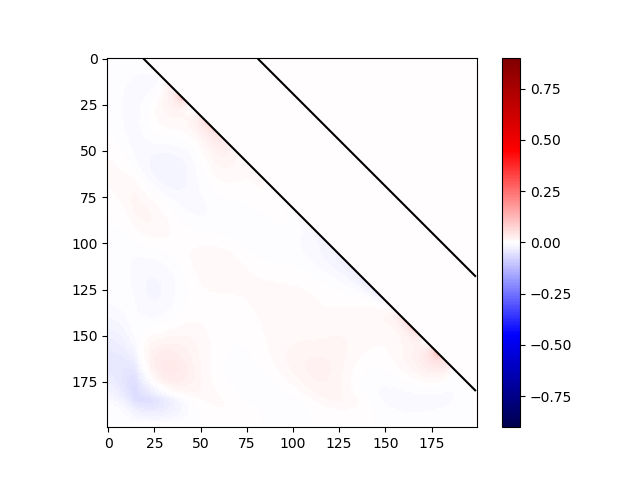

<IPython.core.display.Javascript object>


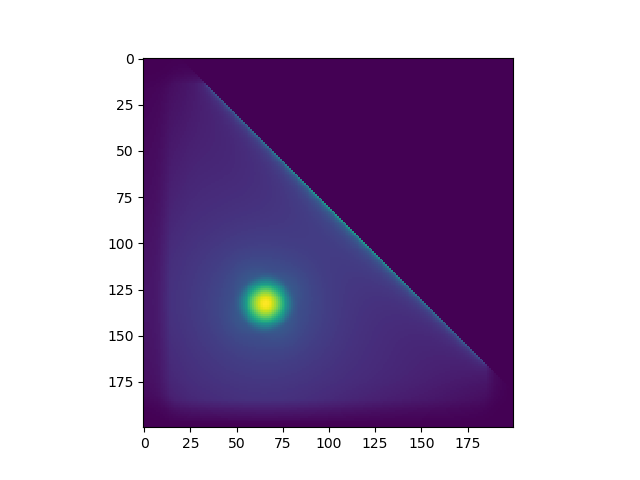

In [382]:
fig = plt.figure(25)
mmax = np.max(np.abs(pondframes))/2
coast = plt.contour(pondrock['h'], levels=1, colors=['black'])
pondart = [(plt.imshow(frame, vmin=-mmax, vmax=mmax, cmap='seismic'),) for frame in pondframes]

anim = animation.ArtistAnimation(fig, pondart, interval=100, blit=True, repeat_delay=200)
plt.colorbar()
# anim.save('../results/simpleplop.mp4')
plt.show()
fig = plt.figure(27)
plt.imshow(pondMax)

# Simulating multiple tsunamis around Palu

### setting up conditions for all the Palu Simulations

In [29]:
palu = {}
latran = (-1.2, 0.2) # latitude range map covers
lonran = (118.7, 121) # longitude range map covers

# calculate height of map  11100*lat degrees = meters
# calculate width of map  1 lon degree = cos(lat) lat degrees, *11100 = meters
# use lon degree size of average latitude
realsize = (111000*(latran[1]-latran[0]),\
               111000*(lonran[1]-lonran[0])\
                  *np.cos((latran[1]-latran[0])/2))# h, w of map in meters
    
size = (700, 1150)# grid size of the map lat, lon


palu['dx'] = np.float32(realsize[1]/size[1])
palu['dy'] = np.float32(realsize[0]/size[0])
print('dx and dy ', palu['dx'], palu['dy'])

# read in bathymetry data
bathdata = nc.Dataset('../data/bathymetry.nc','r')
bathlat = bathdata.variables['lat']
bathlon = bathdata.variables['lon']
#calculate indexes of bathymetry dataset we need
bathlatix = np.linspace(np.argmin(np.abs(bathlat[:]-latran[0])),\
                        np.argmin(np.abs(bathlat[:]-latran[1])),\
                        size[0], dtype=int)
bathlonix = np.linspace(np.argmin(np.abs(bathlon[:]-lonran[0])),\
                        np.argmin(np.abs(bathlon[:]-lonran[1])),\
                        size[1], dtype=int)
# print(bathlatix, bathlonix)
palu['h'] = np.asarray(-bathdata.variables['elevation'][bathlatix, bathlonix], dtype=np.float32)
palu['lat'] = np.asarray(bathlat[bathlatix])
palu['lon'] = np.asarray(bathlon[bathlonix])

palu['n'] = np.zeros(size, dtype=np.float32)
palu['u'] = np.zeros((size[0]+1,size[1]), dtype=np.float32)
palu['v'] = np.zeros((size[0],size[1]+1), dtype=np.float32)

palu['dt'] = np.float32(0.3)*palu['dx']/np.sqrt(np.max(palu['h']*p.g))
# paluState = State(**palu)

dx and dy  169.79497 222.0


### display coastline to verify correct setup of Palu

<IPython.core.display.Javascript object>


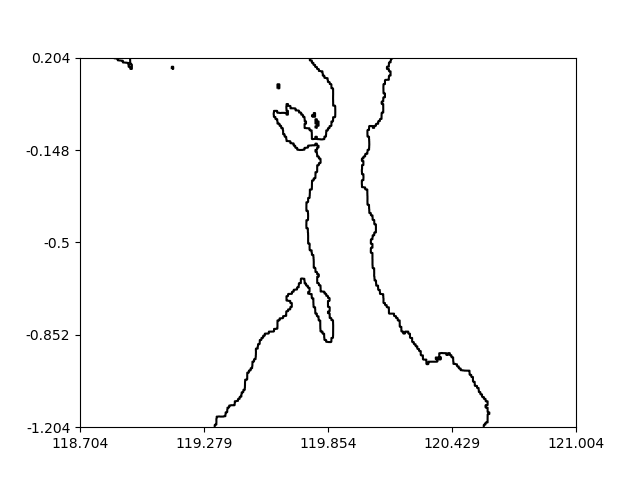

In [30]:

fig = plt.figure(166)
coast = plt.contour(palu['h'], levels=1, colors='black')
xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
           np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
           np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))

### create array of multiple initial conditions of sea surface heights

In [39]:

dist = 33000 # m from mouth of palu bay
center = (-0.63, 119.75) # point events are equidistant from
startang = np.pi/4 # angle of first event
endang = np.pi+0.01 # angle of last event
dang = np.pi/16 # change in angle

argcenter = (np.argmin(np.abs(palu['lat']-center[0])), \
             np.argmin(np.abs(palu['lon']-center[1]))) # the index of the center point
argdist = int(dist/palu['dx'])

print(argdist, argcenter)


seiswidth = int(5000/palu['dx'])
seislength = int(10000/palu['dy'])

    

initns = np.array([seismic(palu['n'].shape, \
                              width = seiswidth/2, \
                              length = seislength, \
                              a1 = 4, a2 = 2, \
                              cx = argcenter[0]-np.cos(ang)*argdist, \
                              cy = argcenter[1]-np.sin(ang)*argdist, \
                              theta = ang+np.pi) \
                      for ang in np.arange(startang, endang, dang)]) # array of the lat, lon positions of each event

194 (286, 525)


### display the initial conditions

<IPython.core.display.Javascript object>


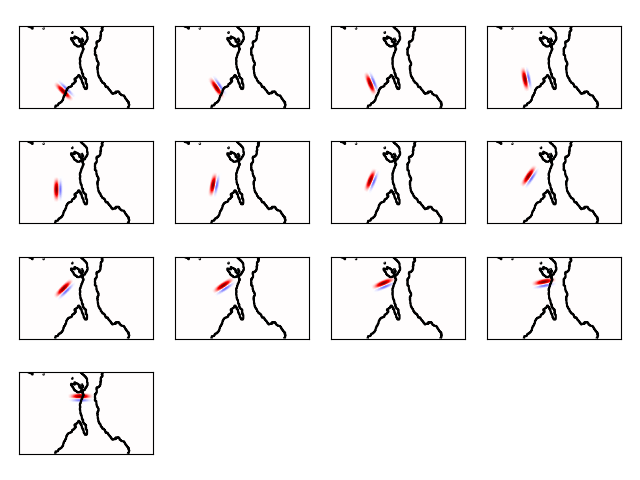

In [40]:

spnum = 1
spcount = initns.shape[0]
plt.figure(176)
mmax = np.max(np.abs(initns))
for initn in initns:
    plt.subplot(int(np.int(np.sqrt(spcount)))+1, spcount/int(np.int(np.sqrt(spcount))), spnum)
    
    # sea surface height
    plt.imshow(initn[::-1], cmap='seismic', vmax=mmax, vmin=-mmax)
    
    # coast
    coast = plt.contour(palu['h'][::-1], levels=1, colors='black')
#     xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
#                np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#     yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
#                np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    plt.xticks([], [])
    plt.yticks([], [])
    
    spnum += 1
plt.tight_layout()

## simulate each event and save the maximum heights from each one

In [ ]:
# paluState = State(**palu)

eventcount = initns.shape[0]

maxes = np.zeros((eventcount,) + palu['n'].shape)#np.array([])
# mins = np.zeros((eventcount,) + palu['n']shape)#np.array([])
# nttmm = np.array([])

evnum = 0 # keep track of which event number were on

for initn in initns:
    initd = dict(palu) # create copy of Palu init conditons
    initd['n'] = initn # with the initial SSH of this specific event
#     initstate = State(**initd) # turn into instance of State class
    
    maxn = simulate(initd, 2500, timestep=genfb, \
                    dudt_x=dudt, dvdt_x=dvdt, dndt_x=dndt, \
                    grav=True, cori=True, advx=True, advy=True, attn=True)[1] # simulate it
    
    print('finished event ' + str(evnum)) # show progress
    
    maxes[evnum] = maxn # record data for this event
#     mins[evnum] = minn
#     maxes[evnum] = maxn
    
    evnum += 1
print('all done')
# save results
np.save('../results/palumaxheights', maxes)

simulating...
simulation complete
finished event 0
simulating...
simulation complete
finished event 1
simulating...
simulation complete
finished event 2
simulating...
simulation complete
finished event 3
simulating...
simulation complete
finished event 4
simulating...
simulation complete
finished event 5
simulating...
simulation complete
finished event 6
simulating...
simulation complete
finished event 7
simulating...
simulation complete
finished event 8
simulating...
simulation complete
finished event 9
simulating...


In [43]:
# or load previous results
# maxes = np.load('../results/palumaxheights.npy')

### display outcomes of each event

<IPython.core.display.Javascript object>


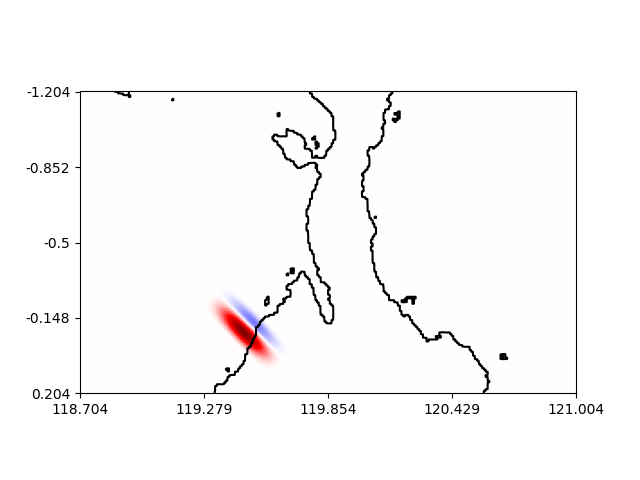

<IPython.core.display.Javascript object>


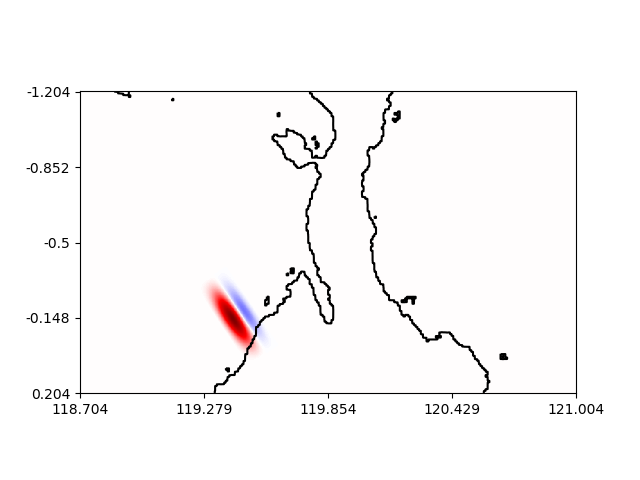

<IPython.core.display.Javascript object>


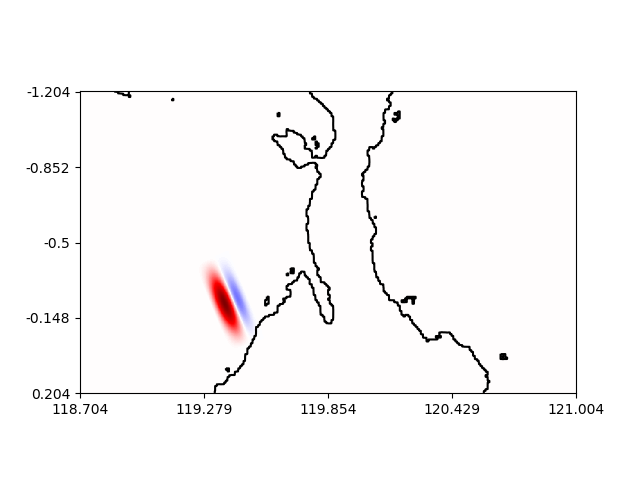

<IPython.core.display.Javascript object>


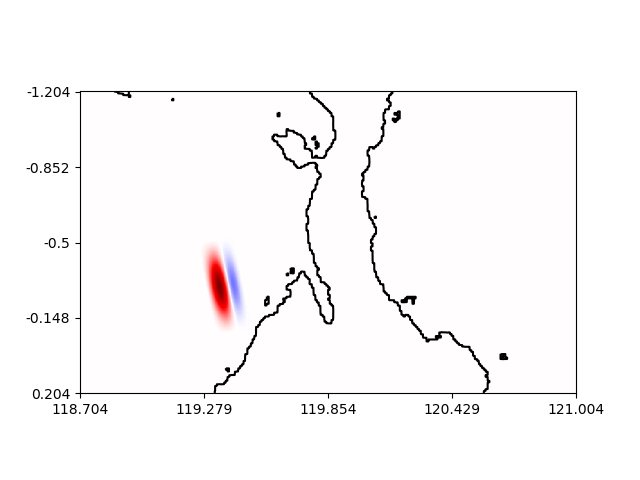

<IPython.core.display.Javascript object>


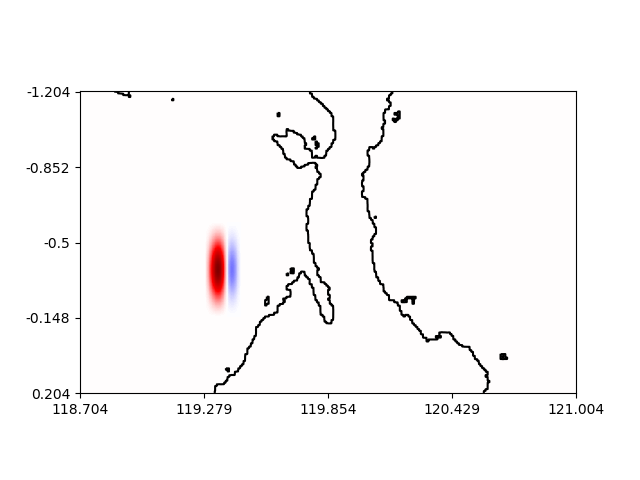

<IPython.core.display.Javascript object>


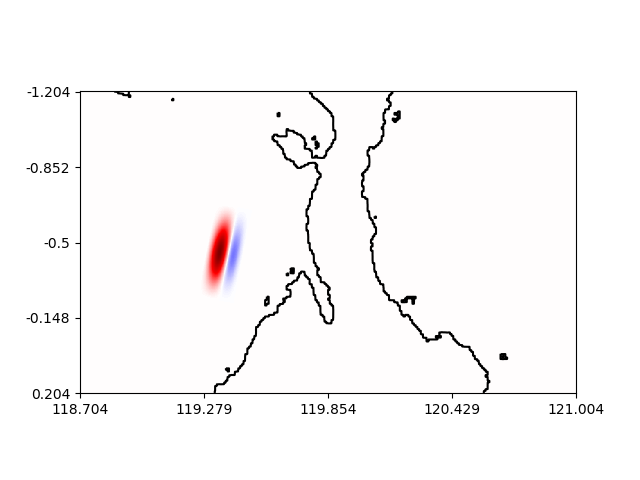

<IPython.core.display.Javascript object>


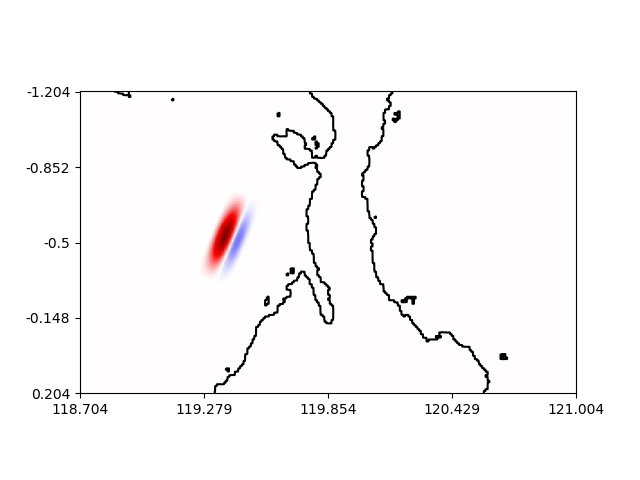

<IPython.core.display.Javascript object>


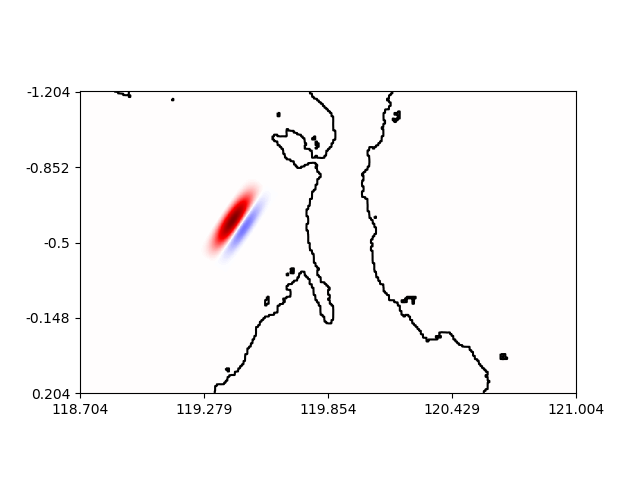

<IPython.core.display.Javascript object>


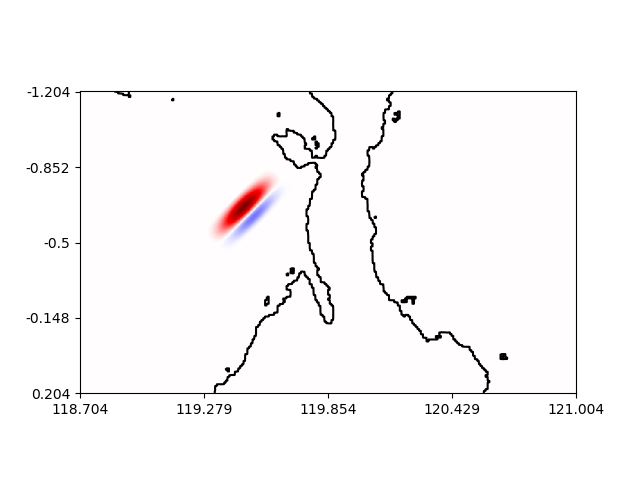

<IPython.core.display.Javascript object>


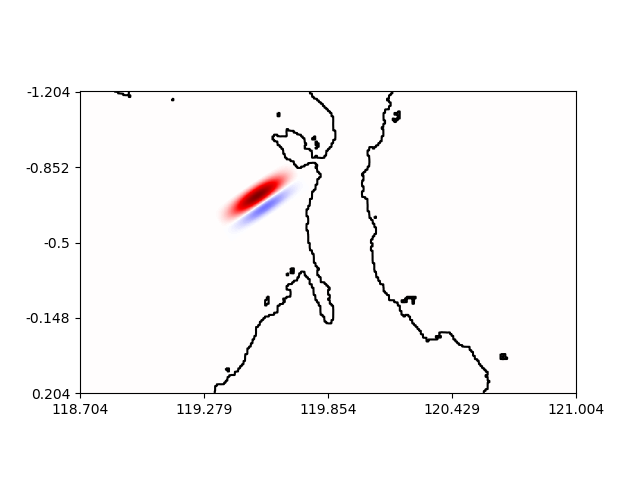

<IPython.core.display.Javascript object>


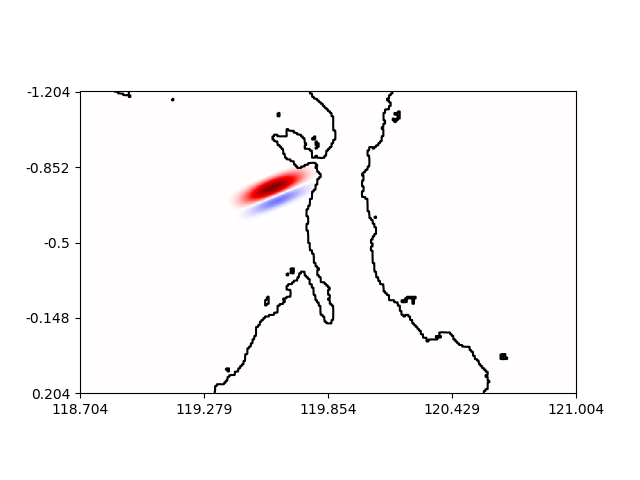

<IPython.core.display.Javascript object>


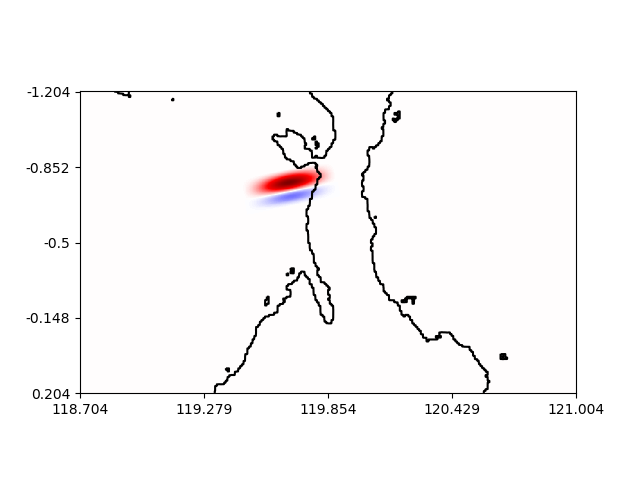

<IPython.core.display.Javascript object>


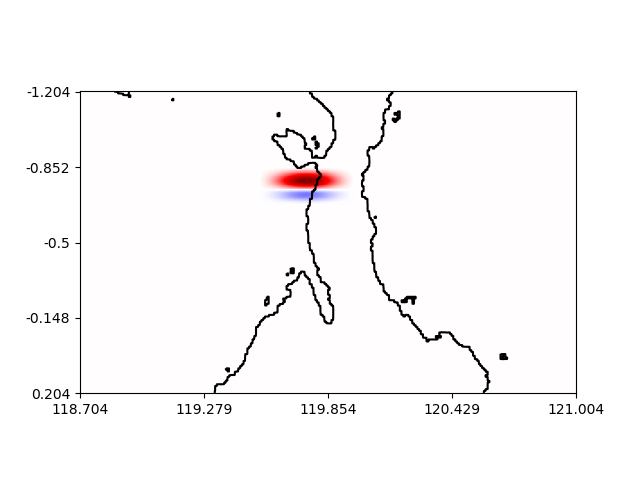

In [42]:
stfignum = 117 # the neighborhood of figure numbers in use

# fignum = 0 # specific figure

#window including just palu bay
pb1 = 150
pb2 = 280
pb3 = 520
pb4 = 600


imax = np.max(initns) # true max of initial SSH's

for fignum, initn in enumerate(initns): # display initial SSH of each event
    fig = plt.figure(stfignum+fignum) # start new figures
    
#     plt.subplot(1, 2, 1)
    plt.imshow(initn[::-1], cmap='seismic', vmax = imax, vmin=-imax)# plot initial condition
#     plt.colorbar()
    coast = plt.contour(palu['h'][::-1]-1.5, levels=1, colors='black') # plot coast
    
    # use latitude, longitude tick markers
    xtixks = plt.xticks(np.linspace(0, palu['h'][::-1].shape[1], 5),\
               np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
    yticks = plt.yticks(np.linspace(0, palu['h'][::-1].shape[0], 5),\
               np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    # use no tickmarks
#     plt.xticks([], [])
#     plt.yticks([], [])
    
    plt.savefig('../results/palu-init-seismic-' + str(fignum)) # download image
    
#     fignum+=1 # next figure
 # repeat of last with colorbar
# plt.figure(stfignum+13)
# plt.imshow(initns[-1], cmap='seismic', vmax=imax, vmin=-imax)
# plt.colorbar()
# plt.savefig('../results/palu-init-cb')
# fignum+=1

In [ ]:
mmax = np.max(maxes[:,pb1:pb2,pb3:pb4]) # true max of maxes
for fignum, maxn in enumerate(maxes): # display maximum heights in palu bay of each event
    fig = plt.figure(stfignum+fignum+14) # start new figure
    
#     plt.subplot(1, 2, 2)
    plt.imshow(maxn[pb2:pb1:-1, pb3:pb4], cmap='nipy_spectral', vmax=mmax, vmin=0) # show max height image
    plt.colorbar()
    coast = plt.contour(palu['h'][pb2:pb1:-1, pb3:pb4]-1.5, levels=1, colors='black') # the coast
    
    # use latitude, longitude tickmarks
#     xtixks = plt.xticks(np.linspace(0, palu['h'].shape[1], 5),\
#                np.round(np.linspace(palu['lon'][0], palu['lon'][-1], 5), 3))
#     yticks = plt.yticks(np.linspace(0, palu['h'].shape[0], 5),\
#                np.round(np.linspace(palu['lat'][0], palu['lat'][-1], 5), 3))
    # use no tickmarks
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.savefig('../results/palu-max-' + str(fignum)) # download image
    
#     fignum += 1 # next figure
# repeat of last event, but with colorbar
# plt.figure(stfignum+27)
# plt.imshow(maxes[-1][pb2:pb1:-1, pb3:pb4], cmap='nipy_spectral', vmax=mmax, vmin=0)
# plt.colorbar()
# plt.savefig('../results/palu-max-cb')plt.colorbar()